# Model testing for CBIR
The model that was selcted for this task is VGG-16 that was trained on 8-block encrypted images. The notebook will be divided into four sections

**Section 1:** Preprocessing: In this section google drive will be mounted, the data will be loaded and the model will be loaded.

**Section 2:** Trying out different block sizes if the this gives good results then it will be tried before and after quantizaton.

**Section 3:** Adding noise to the data to see how robust the model is

**Section 4:** Non completness test for images

## Section 1 Preprocessing

This section will mount the google drive get the data setup the encryption class and get the original model

In [1]:
try :
    import timm
except ModuleNotFoundError:
    !pip install timm -q
    import timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
!mkdir data
!unzip /content/drive/MyDrive/Bustati/potato.zip -d data

Archive:  /content/drive/MyDrive/Bustati/potato.zip
   creating: data/train/
   creating: data/train/bone/
  inflating: data/train/bone/1436.png  
  inflating: data/train/bone/11677.png  
  inflating: data/train/bone/7883.png  
  inflating: data/train/bone/7295.png  
  inflating: data/train/bone/14109.png  
  inflating: data/train/bone/11574.png  
  inflating: data/train/bone/15107.png  
  inflating: data/train/bone/14285.png  
  inflating: data/train/bone/9157.png  
  inflating: data/train/bone/10960.png  
  inflating: data/train/bone/2373.png  
  inflating: data/train/bone/3567.png  
  inflating: data/train/bone/2298.png  
  inflating: data/train/bone/11539.png  
  inflating: data/train/bone/2819.png  
  inflating: data/train/bone/13546.png  
  inflating: data/train/bone/10685.png  
  inflating: data/train/bone/3654.png  
  inflating: data/train/bone/14712.png  
  inflating: data/train/bone/5273.png  
  inflating: data/train/bone/6981.png  
  inflating: data/train/bone/3343.png  
  i

### 1.1 Preprocessing (encryption)

The class below loads and encrypts the images and is used a a PyTorch transfroms

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch
from torchvision import transforms

class ImageEncryption:
    """
    Class for image encryption using a combination of intra-block texture encryption
    and color encryption.

    Args:
        m (int): The number of subblocks in each dimension.

    Attributes:
        m (int): The number of subblocks in each dimension.

    Methods:
        image_encryption(image_path):
            Encrypts an image using intra-block texture encryption and color encryption.

        intrablock_texture_encryption(subblock):
            Encrypts a subblock using intra-block texture encryption.

        color_encryption(subblock, i):
            Encrypts a subblock using color encryption.
    """
    def __init__(self, m, split):
        """
        Initializes the ImageEncryption object.

        Args:
            m (int): The number of subblocks in each dimension.
        """
        self.m = m
        self.split = split

    def image_encryption(self, image_path):
        """
        Encrypts an image using intra-block texture encryption and color encryption.

        Args:
            image_path (str): The path to the input image file.

        Returns:
            tuple: A tuple containing the encrypted image, image subkeys, and block keys.
        """
        # Load image using cv2.imread
        open_cv_image = np.array(image_path)
        # Convert RGB to BGR
        open_cv_image = open_cv_image[:, :, ::-1].copy()
        if self.split:
            height,width,color = open_cv_image.shape
            open_cv_image = open_cv_image[:height//2,:width//2,:]
        img = cv2.resize(open_cv_image,(224,224))
        height, width = img.shape[:2]  # Get height and width using img.shape
        w_subblock = width // self.m
        h_subblock = height // self.m

        image_subblocks = []
        for i in range(self.m):
            for j in range(self.m):
                x1 = i * w_subblock
                y1 = j * h_subblock
                x2 = x1 + w_subblock
                y2 = y1 + h_subblock
                subblock = img[y1:y2, x1:x2]  # Crop using array slicing
                image_subblocks.append(subblock)

        encrypted_image_subblocks = []
        key_image_subblocks = []
        for subblock in image_subblocks:
            encrypted_subblock, subK = self.intrablock_texture_encryption(np.array(subblock))
            encrypted_image_subblocks.append(encrypted_subblock)
            key_image_subblocks.append(subK)

        img_sub_key = np.empty(len(encrypted_image_subblocks))
        for i in range(len(encrypted_image_subblocks)-1, -1, -1):
            n = random.randint(0, i)
            encrypted_image_subblocks[i], encrypted_image_subblocks[n] = encrypted_image_subblocks[n], encrypted_image_subblocks[i]
            key_image_subblocks[i], key_image_subblocks[n] = key_image_subblocks[n], key_image_subblocks[i]
            img_sub_key[i] = n

        for i in range(len(encrypted_image_subblocks)):
            encrypted_image_subblocks[i] = self.color_encryption(encrypted_image_subblocks[i], i)

        original_image = np.zeros((height, width, 3))
        for i in range(self.m):
            for j in range(self.m):
                x1 = i * w_subblock
                y1 = j * h_subblock
                x2 = x1 + w_subblock
                y2 = y1 + h_subblock
                original_image[y1:y2, x1:x2] = encrypted_image_subblocks[i * self.m + j]
        encrypted_image_subblocks = original_image

        return encrypted_image_subblocks.astype(np.uint8), img_sub_key, key_image_subblocks

    def intrablock_texture_encryption(self, subblock):
        """
        Encrypts a subblock using intra-block texture encryption.

        Args:
            subblock (numpy.ndarray): The input subblock to be encrypted.

        Returns:
            tuple: A tuple containing the encrypted subblock and a dictionary of subkeys.
        """
        lr, lg, lb = cv2.split(subblock)

        # Flatten the color channels
        lr_flat = lr.flatten()
        lg_flat = lg.flatten()
        lb_flat = lb.flatten()

        # Initialize empty key lists for each channel
        sub_img_r_key = np.empty(lr_flat.shape)
        sub_img_g_key = np.empty(lr_flat.shape)
        sub_img_b_key = np.empty(lr_flat.shape)

        # Random shuffling with key generation
        for i in range(len(lb_flat)-1, -1, -1):
            r = random.randint(0, i)
            sub_img_r_key[i] = r
            g = random.randint(0, i)
            sub_img_g_key[i] = g
            b = random.randint(0, i)
            sub_img_b_key[i] = b

            lr_flat[i], lr_flat[r] = lr_flat[r], lr_flat[i]
            lg_flat[i], lg_flat[g] = lg_flat[g], lg_flat[i]
            lb_flat[i], lb_flat[b] = lb_flat[b], lb_flat[i]

        # Reshape flattened arrays to original shape
        lr_flat = lr_flat.reshape(lr.shape)
        lg_flat = lg_flat.reshape(lg.shape)
        lb_flat = lb_flat.reshape(lb.shape)

        # Merge that to become an RGB image
        encrypted_subblock = cv2.merge((lr_flat, lg_flat, lb_flat))

        # Create subK dictionary to store keys
        subK = {
            "sub_img_r_key": sub_img_r_key,
            "sub_img_g_key": sub_img_g_key,
            "sub_img_b_key": sub_img_b_key
        }
        return encrypted_subblock, subK

    def color_encryption(self, subblock, i):
        """
        Encrypts a subblock using color encryption.

        Args:
            subblock (numpy.ndarray): The input subblock to be encrypted.
            i (int): An index used in the encryption process.

        Returns:
            numpy.ndarray: The encrypted subblock.
        """
        er, eg, eb = cv2.split(subblock)
        er_flat = er.flatten()
        eg_flat = eg.flatten()
        eb_flat = eb.flatten()

        eb_flat_ = np.asarray([(e + i / self.m * 256 / self.m) % 256 for e in er_flat]).astype(int)
        er_flat_ = np.asarray([(e + (i % self.m) * 256 / self.m) % 256 for e in eg_flat]).astype(int)
        eg_flat_ = np.asarray([(e + (i / self.m + i % self.m) * 128 / self.m) % 256 for e in eb_flat]).astype(int)

        er_flat_ = er_flat_.reshape(er.shape)
        eg_flat_ = eg_flat_.reshape(eg.shape)
        eb_flat_ = eb_flat_.reshape(eb.shape)

        encrypted_subblock = cv2.merge((er_flat_, eg_flat_, eb_flat_))

        return encrypted_subblock.astype(np.uint8)


class ImageEncryptionTransform(object):
    def __init__(self, m,add_noise=False,split=False):
        super().__init__()
        self.m = m
        self.add_noise = add_noise
        self.image_encryption = ImageEncryption(m,split)  # Create an instance of your class

    def __call__(self, img):
        # Process the image using the image_encryption object
        encrypted_img, _, _ = self.image_encryption.image_encryption(img)
        encrypted_img = encrypted_img.astype(np.float32)
        if self.add_noise:
            encrypted_img += np.random.rand(encrypted_img.shape[0],encrypted_img.shape[1],encrypted_img.shape[2])
        encrypted_img/=255.0
        encrypted_img = torch.from_numpy(encrypted_img)
        return encrypted_img.permute(2,0,1)


### 1.2 Loading the model and the data

In [5]:
import timm
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tqdm.auto import tqdm


def load_model(path:str="/content/drive/MyDrive/Bustati/Bustati/best_vgg.pth"):
    """
    Loads the saved model from google drive

    Args:
        path: the path of the model weights
    """
    model = timm.create_model("vgg16",num_classes=3)
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    return model

def load_data(data_path:str,transforms, batch_size):
    """
    loads the data and applies the required transforms (preprocessing)

    Args:
        data_path: the directory of the path
        transforms: the encryption of the image
        batch_size: the number of batchees duh

    Returns:
        the loaded data as PyTorch DataLoader
    """

    test_data = ImageFolder(
    data_path,
    transform=transforms,
        )
    data_loader = DataLoader(
    test_data,
    shuffle=False,
    num_workers=int(os.cpu_count()),
    batch_size=batch_size
    )
    return data_loader


def evaluate_model(model,data_loader,show_fig=True)->None:
    """
    Evaluates the model and prints the classification report

    Args:
        model: a PyTorch model
        data_loader: PyTorch data loader
        show_fig: whther or not to show the confusion matrix
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    y_true = []
    y_hat = []
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y=X.to(device),y.to(device)
            y_logits = model(X).softmax(axis=1)
            y_preds = y_logits.argmax(axis=1)
            y_true.append(y)
            y_hat.append(y_preds)
        y_true=torch.cat(y_true,0)
        y_hat=torch.cat(y_hat,0)

    if y_true.device != "cpu":
        y_true = y_true.cpu().numpy()
        y_hat = y_hat.cpu().numpy()
    else:
        y_true = y_true.numpy()
        y_hat = y_hat.numpy()

    print(classification_report(y_true,y_hat))

    if show_fig:
        cf = confusion_matrix(y_true,y_hat)
        disp = ConfusionMatrixDisplay(cf,display_labels=["bone","chest","mri"])
        disp.plot()
        plt.show()

### 1.3 Quantization

Below are the two ways used for quantization which are quantizaing only a selcted number of layers and quantizaing the whole model

In [6]:
import torch
import torch.nn.functional as F
import copy


def calculate_kl_divergence_scale(param_tensor):
    # Assuming Gaussian distributions for simplicity
    device = param_tensor.device
    original_distribution = torch.distributions.Normal(torch.mean(param_tensor), torch.std(param_tensor))
    quantized_distribution = torch.distributions.Normal(0, 1.0)  # Assuming a standard normal distribution

    # Generate samples from the original and quantized distributions
    original_samples = original_distribution.sample((param_tensor.numel(),)).to(device)
    quantized_samples = quantized_distribution.sample((param_tensor.numel(),)).to(device)

    # Calculate KL divergence
    kl_divergence = F.kl_div(F.log_softmax(original_samples, dim=0), F.softmax(quantized_samples, dim=0), reduction='batchmean')

    # Convert KL divergence to a scale factor
    kl_divergence_scale = torch.exp(-kl_divergence)

    return kl_divergence_scale

def calculate_alpha(model,params=None):

    quantization_scales = {"kl": [], "max": [], "99%": []}
    if params is None:
        params = model.state_dict().keys()

    for param_tensor in params:
        tensor = model.state_dict()[param_tensor]


        # Randomly shuffle indices and select a subset of the tensor
        sample_size = min(1000, tensor.numel())  # Adjust the sample size as needed
        indices = torch.randperm(tensor.numel())[:sample_size]
        sampled_tensor = tensor.view(-1)[indices]

        max_scale = torch.max(torch.abs(model.state_dict()[param_tensor]))
        percentile_99_scale = torch.quantile(torch.abs(model.state_dict()[param_tensor]), 0.99)

        # Calculate KL divergence-based scale
        kl_divergence_scale = calculate_kl_divergence_scale(model.state_dict()[param_tensor])
        quantization_scales["kl"].append(kl_divergence_scale.item())
        quantization_scales["max"].append(max_scale.item())
        quantization_scales["99%"].append(percentile_99_scale.item())

    return quantization_scales


def apply_quantization(params,model,scale):
    weights = copy.deepcopy(model.state_dict())
    model = copy.deepcopy(model)
    for i,param_tensor in enumerate(params):


        s = (2**8-1)/(scale[i])
        quantized_param = weights[param_tensor]*s
        quantized_param = torch.clip(quantized_param,min=-s,max=s)
        weights[param_tensor].data = quantized_param.data
    return model.load_state_dict(weights)


## Section 2 testing diffrent block size

### 2.1 1 Block

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.04      0.08       100
           1       0.34      0.97      0.51       100
           2       0.69      0.09      0.16       100

    accuracy                           0.37       300
   macro avg       0.68      0.37      0.25       300
weighted avg       0.68      0.37      0.25       300



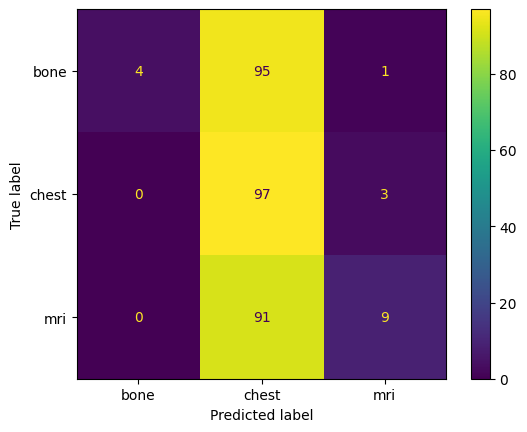

In [7]:
from torchvision import transforms
model = load_model()
transform  = transforms.Compose([
    ImageEncryptionTransform(m=1),  # Apply encryption with desired number of subblocks
])

dataloader =load_data("/content/data/test",transform,32)
evaluate_model(model,dataloader,show_fig=True)

In [8]:
quantization_scales = calculate_alpha(model,params = ['head.fc.weight', 'head.fc.bias'])
quantization_scales

{'kl': [0.9999601244926453, 0.9641678333282471],
 'max': [0.14140529930591583, 0.07010690867900848],
 '99%': [0.03851763904094696, 0.06944004446268082]}

### 2.2 8 Blocks

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       100
           1       0.98      0.94      0.96       100
           2       0.95      0.94      0.94       100

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



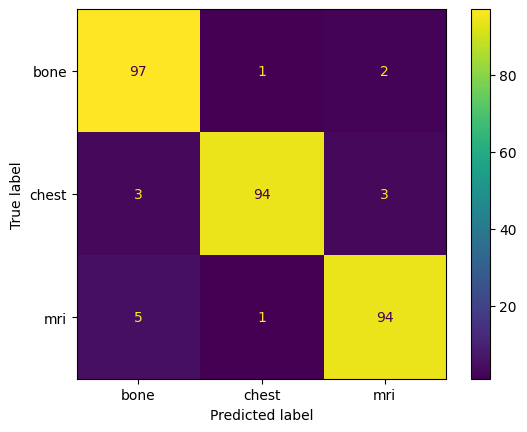

In [9]:
from torchvision import transforms
model = load_model()
transform  = transforms.Compose([
    ImageEncryptionTransform(m=8),  # Apply encryption with desired number of subblocks
])

dataloader =load_data("/content/data/test",transform,32)
evaluate_model(model,dataloader,show_fig=True)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       100
           1       0.98      0.95      0.96       100
           2       0.94      0.99      0.97       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



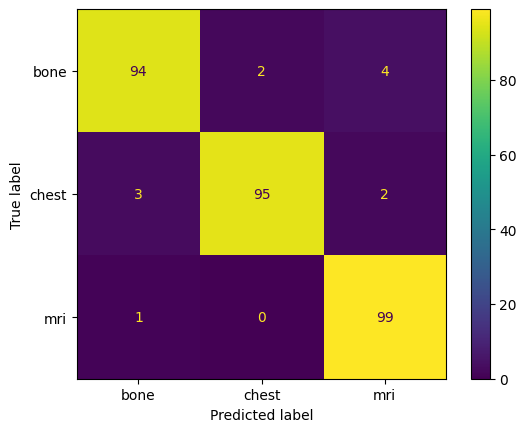

In [10]:
params = ['head.fc.weight', 'head.fc.bias']
quantization_scales = calculate_alpha(model,params = params)
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["kl"])
evaluate_model(model,dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       100
           1       0.98      0.93      0.95       100
           2       0.91      0.97      0.94       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



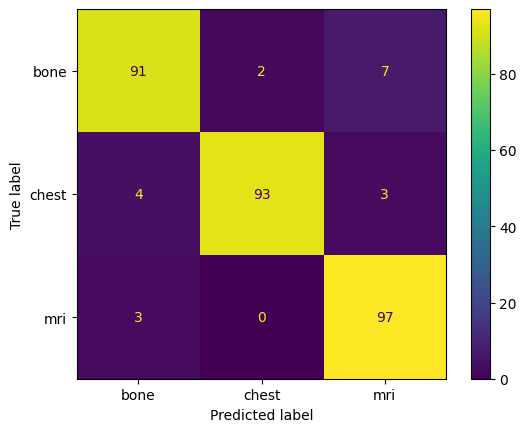

In [11]:
params = ['head.fc.weight', 'head.fc.bias']
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["99%"])
evaluate_model(model,dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       100
           1       0.96      0.91      0.93       100
           2       0.93      0.95      0.94       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



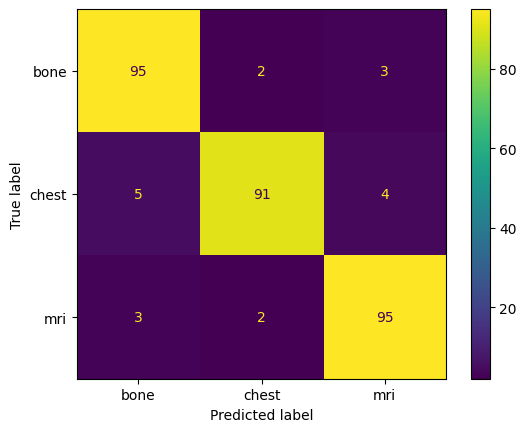

In [12]:
params = ['head.fc.weight', 'head.fc.bias']
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["max"])
evaluate_model(model,dataloader)

### 2.3 16 blocks

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       100
           1       0.86      0.96      0.91       100
           2       0.99      0.84      0.91       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



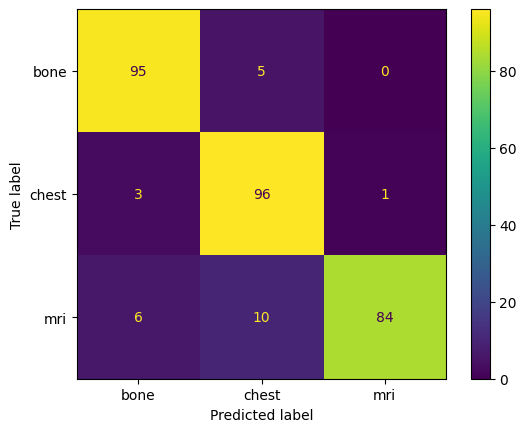

In [13]:
from torchvision import transforms
model = load_model()
transform  = transforms.Compose([
    ImageEncryptionTransform(m=16),  # Apply encryption with desired number of subblocks
])

dataloader =load_data("/content/data/test",transform,32)
evaluate_model(model,dataloader,show_fig=True)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       100
           1       0.81      0.96      0.88       100
           2       0.99      0.85      0.91       100

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300



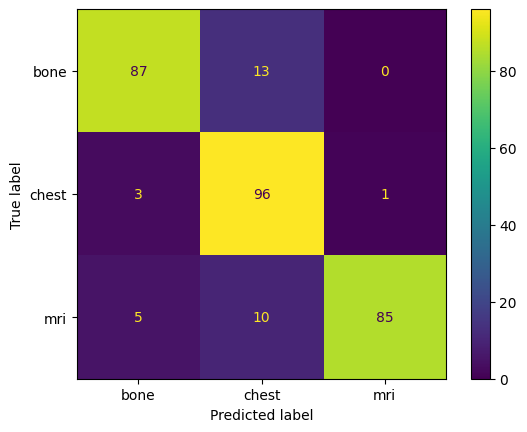

In [14]:
params = ['head.fc.weight', 'head.fc.bias']
quantization_scales = calculate_alpha(model,params = params)
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["kl"])
evaluate_model(model,dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       100
           1       0.84      0.96      0.90       100
           2       0.99      0.84      0.91       100

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



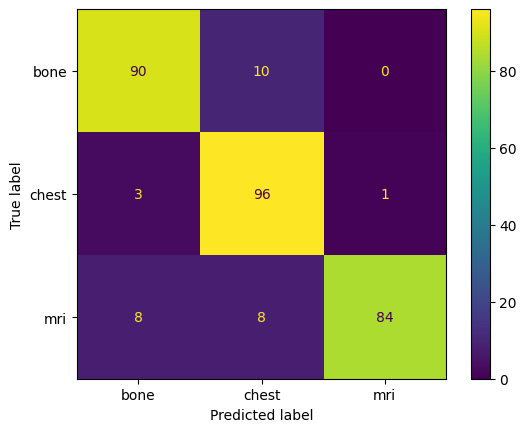

In [15]:
params = ['head.fc.weight', 'head.fc.bias']
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["99%"])
evaluate_model(model,dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       100
           1       0.88      0.96      0.92       100
           2       0.99      0.87      0.93       100

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



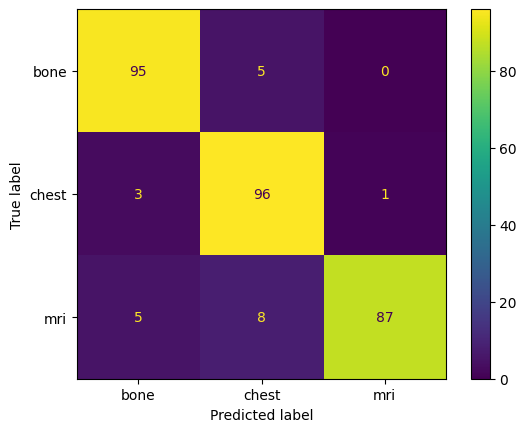

In [16]:
params = ['head.fc.weight', 'head.fc.bias']
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["max"])
evaluate_model(model,dataloader)

### 2.4 32 Blocks

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.28      0.41       100
           1       0.46      0.97      0.62       100
           2       0.98      0.49      0.65       100

    accuracy                           0.58       300
   macro avg       0.72      0.58      0.56       300
weighted avg       0.72      0.58      0.56       300



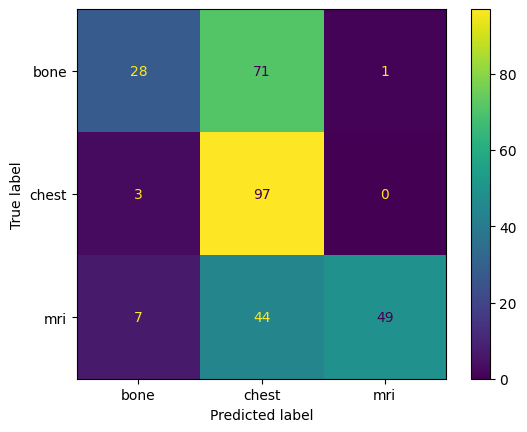

In [17]:
from torchvision import transforms
model = load_model()
transform  = transforms.Compose([
    ImageEncryptionTransform(m=32),  # Apply encryption with desired number of subblocks
])

dataloader =load_data("/content/data/test",transform,32)
evaluate_model(model,dataloader,show_fig=True)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.79      0.31      0.45       100
           1       0.47      0.96      0.63       100
           2       0.96      0.55      0.70       100

    accuracy                           0.61       300
   macro avg       0.74      0.61      0.59       300
weighted avg       0.74      0.61      0.59       300



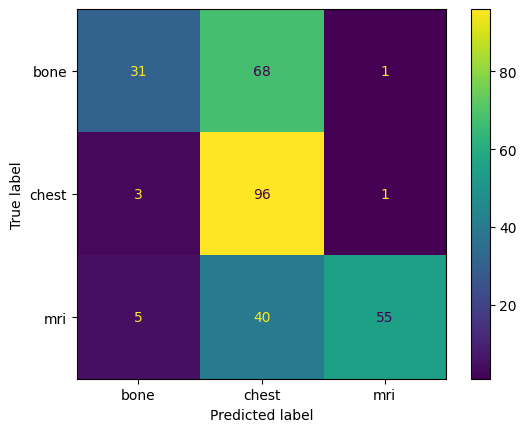

In [18]:
params = ['head.fc.weight', 'head.fc.bias']
quantization_scales = calculate_alpha(model,params = params)
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["kl"])
evaluate_model(model,dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.71      0.27      0.39       100
           1       0.45      0.96      0.61       100
           2       0.98      0.46      0.63       100

    accuracy                           0.56       300
   macro avg       0.71      0.56      0.54       300
weighted avg       0.71      0.56      0.54       300



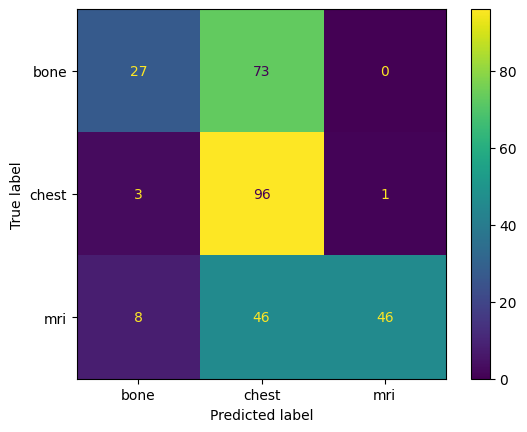

In [19]:
params = ['head.fc.weight', 'head.fc.bias']
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["99%"])
evaluate_model(model,dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.79      0.26      0.39       100
           1       0.46      0.98      0.62       100
           2       1.00      0.52      0.68       100

    accuracy                           0.59       300
   macro avg       0.75      0.59      0.57       300
weighted avg       0.75      0.59      0.57       300



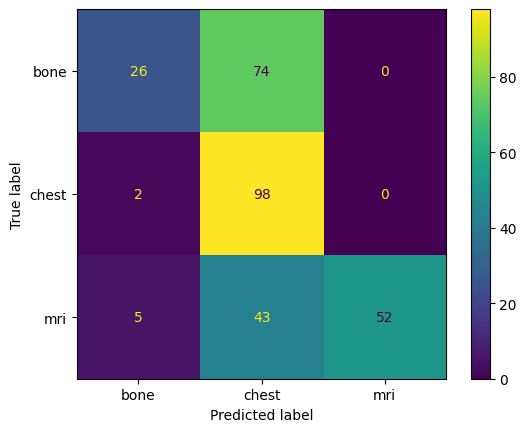

In [20]:
params = ['head.fc.weight', 'head.fc.bias']
model1 = apply_quantization(params=params,
                            model=model,
                            scale=quantization_scales["max"])
evaluate_model(model,dataloader)

## Section 3: Adding noise

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       100
           1       0.97      0.95      0.96       100
           2       0.96      0.95      0.95       100

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



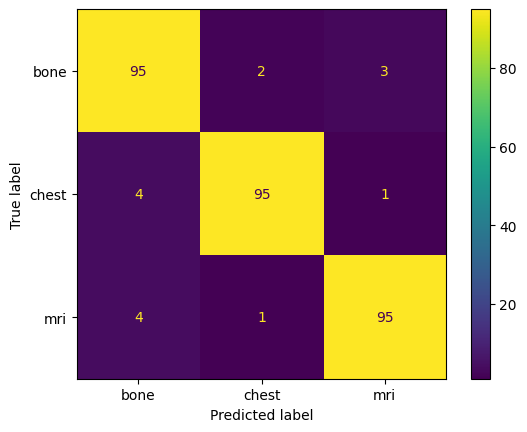

In [21]:
from torchvision import transforms
model = load_model()
transform  = transforms.Compose([
    ImageEncryptionTransform(m=8,add_noise=True),  # Apply encryption with desired number of subblocks
])

dataloader =load_data("/content/data/test",transform,32)
evaluate_model(model,dataloader,show_fig=True)

## Section 4: Non-completness test

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.69      0.52      0.59       100
           1       0.96      0.65      0.77       100
           2       0.59      0.93      0.72       100

    accuracy                           0.70       300
   macro avg       0.75      0.70      0.70       300
weighted avg       0.75      0.70      0.70       300



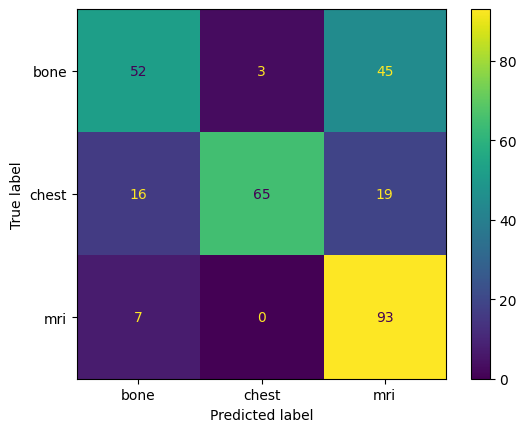

In [22]:
from torchvision import transforms
model = load_model()
transform  = transforms.Compose([
    ImageEncryptionTransform(m=8,split=True),  # Apply encryption with desired number of subblocks
])

dataloader =load_data("/content/data/test",transform,32)
evaluate_model(model,dataloader,show_fig=True)